In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import load_poker_data, analyze_class_distribution
from src.feature_engineering import PokerFeatureEngine

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

In [ ]:
train_df = pd.read_csv('../data/poker-hand-training.csv')
print("Columns:", train_df.columns.tolist())
print("\nFirst 3 rows:")
print(train_df.head(3))
print("\nData types:")
print(train_df.dtypes)
print("\nShape:", train_df.shape)

Columns: ['Suit of Card 1', 'Rank of Card 1', 'Suit of Card 2', 'Rank of Card 2', 'Suit of Card 3', 'Rank of Card 3', 'Suit of Card 4', 'Rank of Card 4', 'Suit of Card 5', 'Rank of Card 5', 'Poker Hand']

First 3 rows:
   Suit of Card 1  Rank of Card 1  Suit of Card 2  Rank of Card 2  \
0               1              10               1              11   
1               2              11               2              13   
2               3              12               3              11   

   Suit of Card 3  Rank of Card 3  Suit of Card 4  Rank of Card 4  \
0               1              13               1              12   
1               2              10               2              12   
2               3              13               3              10   

   Suit of Card 5  Rank of Card 5  Poker Hand  
0               1               1           9  
1               2               1           9  
2               3               1           9  

Data types:
Suit of Card 1    int6

### Data Structure Overview

The dataset contains 11 columns representing a 5-card poker hand:
- **10 input features**: Alternating suit and rank for each of 5 cards
- **1 target variable**: Poker hand classification (0-9)

**Encoding scheme:**
- Suits are integers 1-4 (Hearts, Spades, Diamonds, Clubs)
- Ranks are integers 1-13 (Ace=1, numbered cards=face value, Jack=11, Queen=12, King=13)
- Target classes range from 0 (Nothing) to 9 (Royal Flush)

**Data quality observations:**
- All columns are int64 type with no missing values
- This is clean, preprocessed data - unusual for real-world projects but ideal for demonstrating methodology
- Training set contains 25,010 observations

**First three samples:**
All three rows represent Royal Flush (class 9). The first row decodes to 10-J-K-Q-A of Hearts. This suggests the dataset may be sorted by hand value, which we'll verify in the distribution analysis.

In [3]:
# Load data
train_df, test_df = load_poker_data(
    '../data/poker-hand-training.csv',
    '../data/poker-hand-testing.csv'
)

train_df.head(10)

Training set: 25,010 hands
Test set: 1,000,000 hands


,S1,R1,S2,R2,S3,R3,S4,R4,S5,R5,hand
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9
5,1,2,1,4,1,5,1,3,1,6,8
6,1,9,1,12,1,10,1,11,1,13,8
7,2,1,2,2,2,3,2,4,2,5,8
8,3,5,3,6,3,9,3,7,3,8,8
9,4,1,4,4,4,2,4,3,4,5,8



Class Distribution:
------------------------------------------------------------
0: Nothing              |   12,493 (49.952%)
1: One pair             |   10,599 (42.379%)
2: Two pairs            |    1,206 ( 4.822%)
3: Three of a kind      |      513 ( 2.051%)
4: Straight             |       93 ( 0.372%)
5: Flush                |       54 ( 0.216%)
6: Full house           |       36 ( 0.144%)
7: Four of a kind       |        6 ( 0.024%)
8: Straight flush       |        5 ( 0.020%)
9: Royal flush          |        5 ( 0.020%)


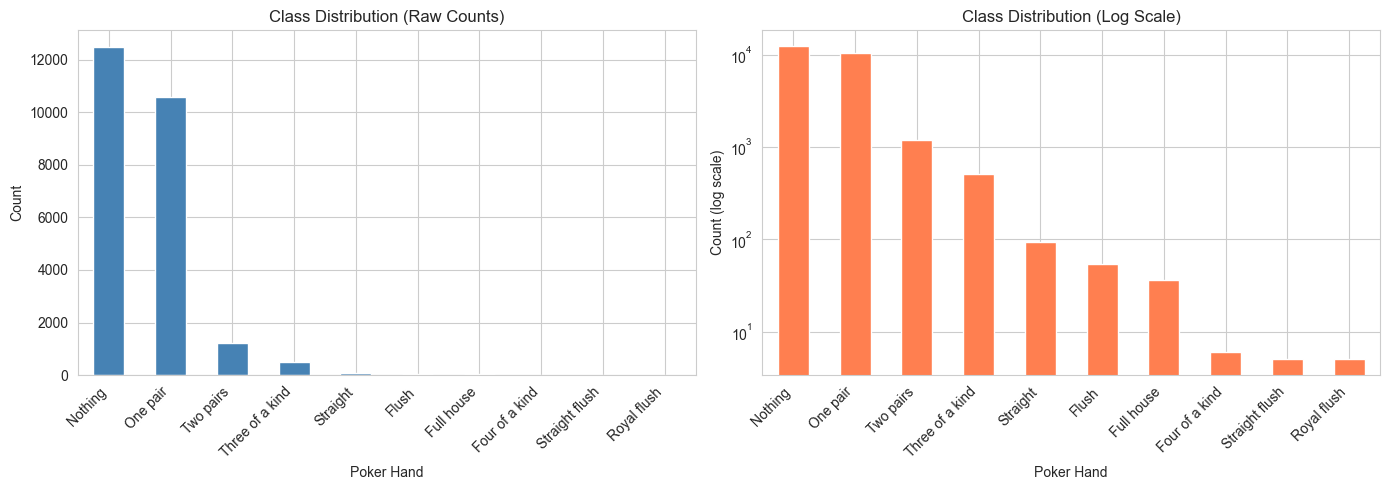

In [4]:
# How bad is the class imbalance?
fig = analyze_class_distribution(train_df)
plt.show()


### The Fundamental Challenge: Extreme Class Imbalance

The distribution reveals a severe imbalance that mirrors real poker probabilities:

**Dominant classes:**
- "Nothing" and "One pair" together account for 92.3% of all hands
- These are the statistically most common outcomes in poker

**Rare classes:**
- Royal Flush appears only 5 times in 25,010 samples (0.020%)
- Four of a Kind, Straight Flush, and Royal Flush combined are less than 0.1% of data
- The rarest class is 2,500 times less frequent than the most common class

**Implications for modeling:**

This imbalance makes standard accuracy a misleading metric. A naive baseline that always predicts "Nothing" would achieve approximately 50% accuracy while being completely useless for identifying rare hands.

**Why this matters:**
- Standard accuracy would reward models that ignore rare classes
- A model could score 92% accuracy by only learning the two dominant classes
- Rare classes (Royal Flush, Straight Flush, Four of a Kind) contain only 16 total examples

**Metric selection:**
This forces us to use metrics that don't reward majority-class bias:
- Balanced Accuracy: Averages recall across all classes equally
- F1 Score (macro): Treats all classes equally regardless of frequency
- F1 Score (weighted): Accounts for class frequency but penalizes poor minority class performance
- Per-class precision and recall: Shows exactly where the model succeeds or fails

**Real-world alignment:**
The distribution approximately reflects actual poker probabilities, though rare hands are oversampled for machine learning purposes. In a truly random deck, Royal Flush occurs once every 649,740 hands.

In [5]:
# Test feature engineering on one row
engine = PokerFeatureEngine()
sample_hand = train_df.iloc[0, :10]  # First 10 columns (cards)

print("\nRaw features:")
print(sample_hand.values)

engineered = engine.transform_row(sample_hand)
print("\nEngineered features:")
for k, v in engineered.items():
    print(f"  {k}: {v}")

true_hand = train_df.iloc[0]['hand']
print(f"\nTrue hand: {PokerFeatureEngine.get_hand_name(true_hand)}")


Raw features:
[ 1 10  1 11  1 13  1 12  1  1]

Engineered features:
  is_flush: 1
  is_straight: 1
  is_royal_straight: 1
  unique_ranks: 5
  max_rank_count: 1
  second_max_rank_count: 1

True hand: Royal flush


### Raw Features vs. Domain-Engineered Features

This example demonstrates the core methodology of the project: transforming positional card data into poker-meaningful features.

**What happened:**
The raw input consists of 10 integers representing suit-rank pairs for 5 cards. These numbers alone don't encode poker logic - a model must learn from scratch that "all suits equal" means flush, or that sequential ranks mean straight.

The engineered features directly encode what a poker player evaluates:

**Binary indicators:**
- `is_flush=1`: All cards share the same suit
- `is_straight=1`: Ranks form a sequential pattern (handles edge case where Ace=1 acts as high card in 10-J-Q-K-A)
- `is_royal_straight=1`: Specifically identifies the 10-J-Q-K-A sequence (critical for distinguishing Royal Flush from other Straight Flushes)

**Rank pattern features:**
- `unique_ranks=5`: All five cards have different ranks
- `max_rank_count=1`: No rank appears more than once
- `second_max_rank_count=1`: The second most frequent rank also appears once

**Why this encoding works:**

For this Royal Flush example, the feature set creates a unique signature: `(1,1,1,5,1,1)`. No other hand type produces this exact combination.

Compare to how these features would look for other hands:
- Regular Straight Flush (e.g., 5-6-7-8-9 suited): `(1,1,0,5,1,1)` - differs only in `is_royal_straight`
- Flush (non-sequential): `(1,0,0,5,1,1)` - has flush but not straight
- Straight (mixed suits): `(0,1,0,5,1,1)` - has straight but not flush
- Four of a Kind: `(0,0,0,2,4,1)` - completely different rank pattern

**The philosophy:**

Instead of forcing a model to learn poker rules from positional data, we encode human expert knowledge directly. This transforms the problem from "learn poker from scratch" to "learn the mapping between feature combinations and hand classifications" - a much simpler task that even linear models can solve perfectly.

**Dimensionality reduction:**
We've reduced the problem from 10 features to 6, while simultaneously making the features more informative. This is feature engineering at its core: fewer, better features.

In [ ]:
# Generate engineered features for entire dataset
print("Transforming training set...")
train_features = engine.transform(train_df)
train_features['hand'] = train_df['hand'].values

print("Transforming test set...")
test_features = engine.transform(test_df)
test_features['hand'] = test_df['hand'].values

train_features.head()


Transforming training set...
Transforming test set...


,is_flush,is_straight,is_royal_straight,unique_ranks,max_rank_count,second_max_rank_count,hand
0,1,1,1,5,1,1,9
1,1,1,1,5,1,1,9
2,1,1,1,5,1,1,9
3,1,1,1,5,1,1,9
4,1,1,1,5,1,1,9


Feature correlation with hand type:
max_rank_count           0.804959
second_max_rank_count    0.433440
is_flush                 0.316478
is_straight              0.311258
is_royal_straight        0.160432
unique_ranks            -0.847532
Name: hand, dtype: float64


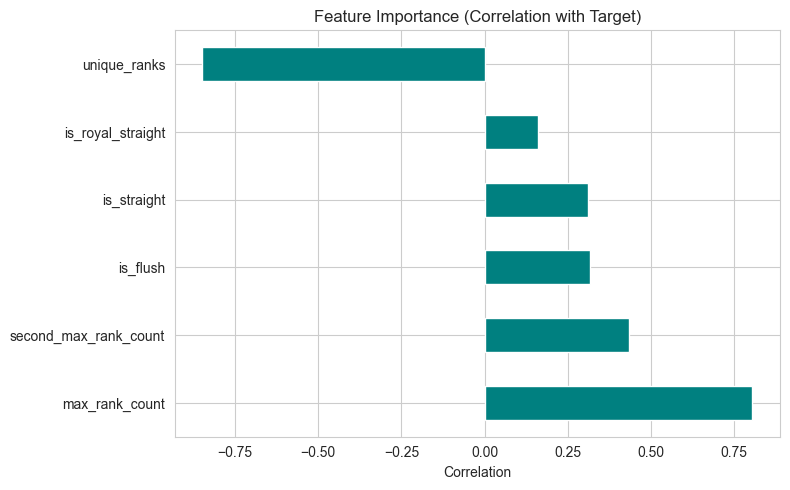

In [7]:
# Feature correlation with target
# This shows which features actually matter

corr_with_target = train_features.corr()['hand'].drop('hand').sort_values(ascending=False)
print("Feature correlation with hand type:")
print(corr_with_target)

plt.figure(figsize=(8, 5))
corr_with_target.plot(kind='barh', color='teal')
plt.title('Feature Importance (Correlation with Target)')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

### Feature Importance Through Correlation

The correlation analysis reveals which features are most predictive of hand value.

**Strongest predictors:**

`unique_ranks` shows the highest correlation magnitude (-0.848, negative). As hand value increases, the number of unique ranks decreases. This makes intuitive sense:
- Low-value hands (Nothing, Straight) have 5 unique ranks
- High-value hands with pairs/trips/quads have 2-4 unique ranks
- Exception: Flush and Straight Flush also have 5 unique ranks, but are detected by other features

`max_rank_count` (+0.805) is the strongest positive predictor. Higher values directly correspond to better hands:
- Nothing/Straight/Flush: max=1
- Pairs: max=2  
- Three of a Kind: max=3
- Four of a Kind: max=4

**Moderate predictors:**

`second_max_rank_count` (+0.433) provides critical disambiguation between hands with the same `max_rank_count`:
- Full House (3,2) vs. Three of a Kind (3,1)
- Two Pairs (2,2) vs. One Pair (2,1)

`is_flush` and `is_straight` (+0.31 each) show moderate correlation because they only activate for specific hand types. However, when both activate simultaneously, they indicate the highest-value hands (Straight Flush, Royal Flush).

**Weakest predictor:**

`is_royal_straight` (+0.160) has the lowest correlation because it only matters for one hand type (Royal Flush), which represents 0.02% of the data. However, this feature is essential for achieving perfect classification - without it, Royal Flush and Straight Flush would be indistinguishable.

**Key insight: Correlation does not equal importance**

Despite low correlation, `is_royal_straight` is critical for perfect classification. This demonstrates that features can have low individual correlation with the target while still being necessary for complete class separation.

**Feature synergy:**

These features work together as logical combinations. Logistic Regression will learn decision boundaries like:
- `is_flush=1 AND is_straight=1 AND is_royal_straight=1` → Royal Flush
- `is_flush=1 AND is_straight=1 AND is_royal_straight=0` → Straight Flush  
- `max_rank_count=3 AND second_max_rank_count=2` → Full House

The features form a complete basis for poker hand evaluation, which is why even a simple linear model can achieve perfect classification.

In [8]:
# Save processed features for modeling
train_features.to_csv('../data/train_engineered.csv', index=False)
test_features.to_csv('../data/test_engineered.csv', index=False)

print("Engineered features saved. Ready for modeling.")

Engineered features saved. Ready for modeling.
